<a href="https://www.kaggle.com/code/jobaerislam/fl-lung-colon?scriptVersionId=283832940" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

In [11]:

# ----- Step 1: Data Transform and Loading -----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Optimized: Create a unified dataset with proper class mapping
import os
from torch.utils.data import Dataset
from PIL import Image

class UnifiedDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.samples = []
        self.classes = []
        
        # Load colon classes
        colon_path = os.path.join(root, 'colon_image_sets')
        colon_classes = sorted(os.listdir(colon_path))
        for cls in colon_classes:
            cls_path = os.path.join(colon_path, cls)
            if os.path.isdir(cls_path):
                self.classes.append(cls)
                class_idx = len(self.classes) - 1
                for img_name in os.listdir(cls_path):
                    img_path = os.path.join(cls_path, img_name)
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((img_path, class_idx))
        
        # Load lung classes
        lung_path = os.path.join(root, 'lung_image_sets')
        lung_classes = sorted(os.listdir(lung_path))
        for cls in lung_classes:
            cls_path = os.path.join(lung_path, cls)
            if os.path.isdir(cls_path):
                self.classes.append(cls)
                class_idx = len(self.classes) - 1
                for img_name in os.listdir(cls_path):
                    img_path = os.path.join(cls_path, img_name)
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((img_path, class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

DATA_ROOT = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'

full_dataset = UnifiedDataset(root=DATA_ROOT, transform=transform)
class_names = full_dataset.classes

print("All 5 Classes:", class_names)
print(f"Total samples: {len(full_dataset)}")

All 5 Classes: ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
Total samples: 25000


In [12]:
# ----- Step 2: Dataset Split: 70/15/15 -----
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Train size: 17500, Val size: 3750, Test size: 3750


In [13]:
# ----- Step 3: Train dataset split for FL clients (3 clients) -----
client_split = [train_size // 3, train_size // 3, train_size - 2 * (train_size // 3)]
client_datasets = random_split(
    train_dataset, client_split,
    generator=torch.Generator().manual_seed(42)
)
client_loaders = [DataLoader(ds, batch_size=16, shuffle=True, num_workers=2) for ds in client_datasets]

# ----- Step 4: Val/Test Loaders -----
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [14]:
# ----- Step 5: Define MobileNetV2 model -----
def create_model():
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, 5)  # Adjust class count if needed
    return model

# ----- Step 6: Local training function -----
def train_local(model, dataloader, epochs=1, lr=1e-3, device='cpu'):
    model.train()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model.state_dict()

In [15]:
# ----- Step 7: Federated averaging (FedAvg) -----
def average_weights(weights_list):
    avg_weights = {}
    for key in weights_list[0].keys():
        avg_weights[key] = torch.stack([w[key].float() for w in weights_list], 0).mean(0)
    return avg_weights


In [16]:

# ----- Step 8: Evaluation function -----
def evaluate(model, dataloader, device='cpu'):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [17]:
# --------- Step 9: Federated Training Loop ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

global_model = create_model()
global_model.to(device)

NUM_ROUNDS = 10
EPOCHS_PER_CLIENT = 1
best_val_acc = 0.0
patience = 2       # Number of rounds with no improvement to wait
wait = 0           # How many rounds since last best

for round_num in range(1, NUM_ROUNDS + 1):
    print(f"\n--- Federated Round {round_num} ---")
    local_weights = []
    client_accuracies = []

    # Each client trains locally
    for i, dataloader in enumerate(client_loaders):
        print(f" Training client {i+1} locally...")
        local_model = create_model()
        local_model.load_state_dict(global_model.state_dict())
        local_weights.append(
            train_local(local_model, dataloader, epochs=EPOCHS_PER_CLIENT, device=device)
        )
        acc = evaluate(local_model, dataloader, device=device)
        client_accuracies.append(acc)
        print(f"  Client {i+1} local accuracy: {acc:.4f}")

    # FedAvg
    averaged_weights = average_weights(local_weights)
    global_model.load_state_dict(averaged_weights)
    print(f" [Server] Aggregated (FedAvg) client weights.")

    # Evaluate global model
    val_acc  = evaluate(global_model, val_loader,  device=device)
    test_acc = evaluate(global_model, test_loader, device=device)
    print(f" [Server] Validation Accuracy: {val_acc:.4f}")
    print(f" [Server] Test Accuracy:       {test_acc:.4f}")

    # --------- Early stopping logic -----------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
        # save the best model here
        torch.save(global_model.state_dict(), 'best_federated_model.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f" Early stopping triggered!\n")
            break


Using device: cuda

--- Federated Round 1 ---
 Training client 1 locally...
  Client 1 local accuracy: 0.9700
 Training client 2 locally...
  Client 2 local accuracy: 0.9335
 Training client 3 locally...
  Client 3 local accuracy: 0.9661
 [Server] Aggregated (FedAvg) client weights.
 [Server] Validation Accuracy: 0.8261
 [Server] Test Accuracy:       0.8355

--- Federated Round 2 ---
 Training client 1 locally...
  Client 1 local accuracy: 0.8956
 Training client 2 locally...
  Client 2 local accuracy: 0.9793
 Training client 3 locally...
  Client 3 local accuracy: 0.9731
 [Server] Aggregated (FedAvg) client weights.
 [Server] Validation Accuracy: 0.9003
 [Server] Test Accuracy:       0.9171

--- Federated Round 3 ---
 Training client 1 locally...
  Client 1 local accuracy: 0.8874
 Training client 2 locally...
  Client 2 local accuracy: 0.9806
 Training client 3 locally...
  Client 3 local accuracy: 0.9637
 [Server] Aggregated (FedAvg) client weights.
 [Server] Validation Accuracy: 0.8

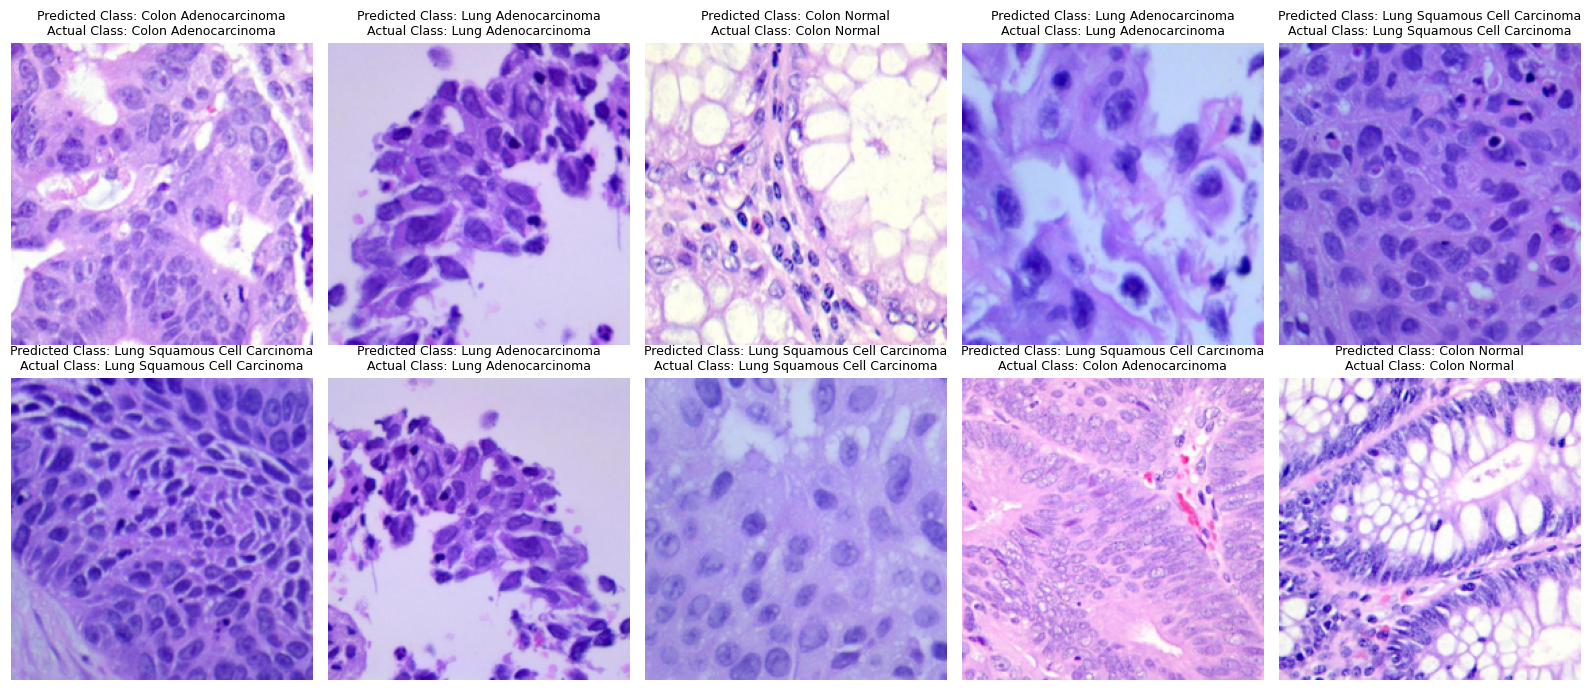

In [18]:
import matplotlib.pyplot as plt
import random

# Define your readable class names (order must match the folders/classes in your dataset)
class_names = [
    "Colon Adenocarcinoma",    # 0
    "Colon Normal",            # 1
    "Lung Adenocarcinoma",     # 2
    "Lung Normal",             # 3
    "Lung Squamous Cell Carcinoma"  # 4
]

# Make sure the global model is in evaluation mode and on CPU for inference
global_model.eval()
global_model.to('cpu')

# Randomly pick 10 unique indices from the test set
indices = random.sample(range(len(test_dataset)), 10)

# Create a 2x5 grid for 10 images
fig, axes = plt.subplots(2, 5, figsize=(16, 7))

for ax, idx in zip(axes.flat, indices):
    image, label = test_dataset[idx]
    input_tensor = image.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = global_model(input_tensor)
        _, pred = torch.max(output, 1)
        predicted_label = pred.item()

    # Unnormalize and show image
    img = image.permute(1, 2, 0).numpy()
    # img = np.clip(img, 0, 1)  # Only needed if you did normalization (not done here)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(
        f"Predicted Class: {class_names[predicted_label]}\nActual Class: {class_names[label]}",
        fontsize=9
    )

plt.tight_layout()
plt.show()


DATASET INITIALIZATION
Classes: ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
Class distribution: {'colon_aca': 5000, 'colon_n': 5000, 'lung_aca': 5000, 'lung_n': 5000, 'lung_scc': 5000}
Total samples: 25000

Train: 17499, Val: 3751, Test: 3750

Client 1: 5833 samples
  Class distribution: {'lung_n': 1166, 'colon_n': 1167, 'colon_aca': 1167, 'lung_scc': 1167, 'lung_aca': 1166}

Client 2: 5833 samples
  Class distribution: {'colon_n': 1167, 'lung_n': 1167, 'lung_aca': 1167, 'colon_aca': 1166, 'lung_scc': 1166}

Client 3: 5833 samples
  Class distribution: {'lung_scc': 1167, 'colon_n': 1166, 'lung_aca': 1167, 'colon_aca': 1167, 'lung_n': 1166}

FEDERATED LEARNING TRAINING
Device: cuda

Configuration: 10 rounds × 5 epochs/client

ROUND 1/10

[Client 1] 5833 samples
    Epoch 1/5 - Loss: 0.215396, Acc: 0.924053
    Epoch 2/5 - Loss: 0.067127, Acc: 0.978913
    Epoch 3/5 - Loss: 0.041163, Acc: 0.987656
    Epoch 4/5 - Loss: 0.021621, Acc: 0.993828
    Epoch 5/5 - Loss: 0.015983

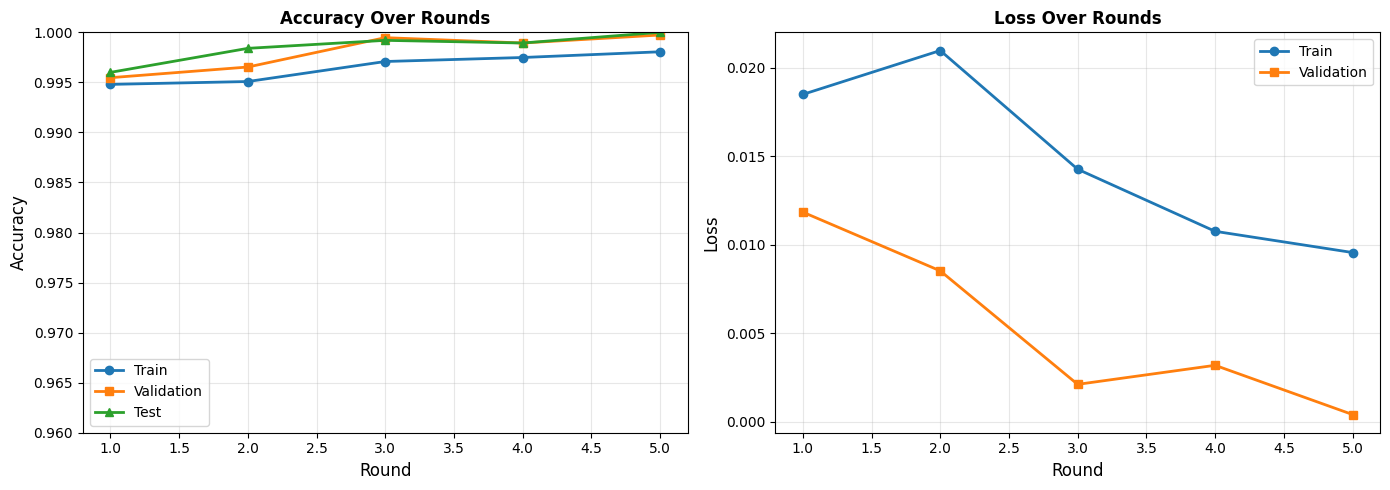

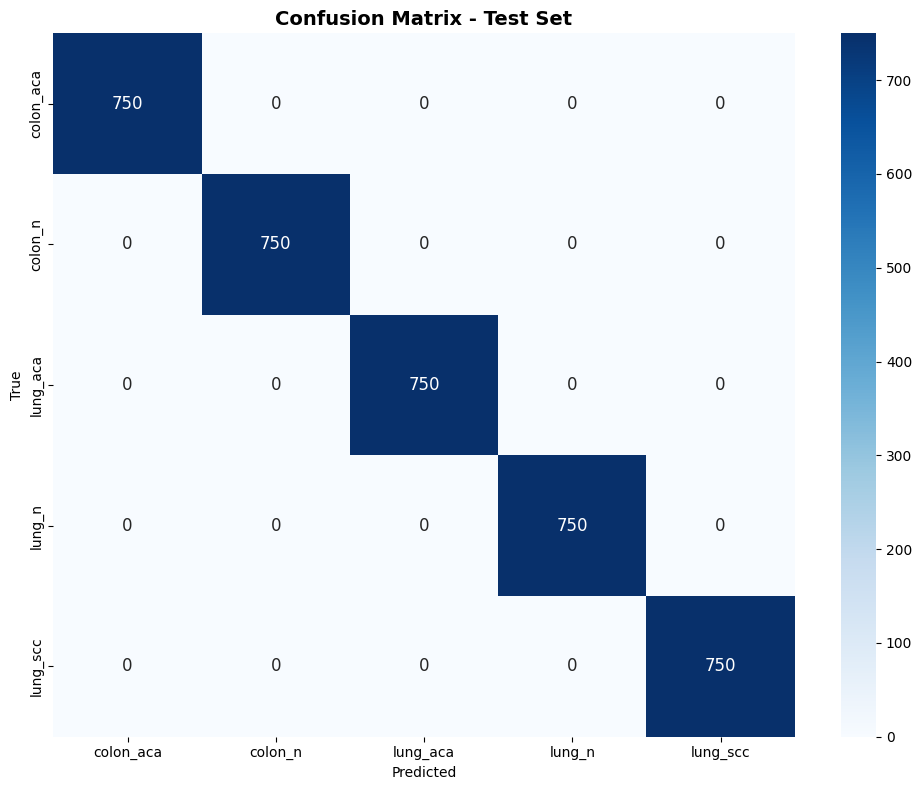


3. Per-Class Metrics Diagram...


NameError: name 'precision_recall_fscore_support' is not defined

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ===== 1. CLEAN DATASET LOADING WITH IMAGEFOLDER =====
DATA_ROOT = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'

# Load colon and lung datasets separately
colon_dataset = datasets.ImageFolder(root=f"{DATA_ROOT}/colon_image_sets", transform=None)
lung_dataset = datasets.ImageFolder(root=f"{DATA_ROOT}/lung_image_sets", transform=None)

class CombinedCancerDataset(Dataset):
    def __init__(self, colon_ds, lung_ds, transform=None):
        """
        Combines colon and lung datasets with proper label remapping
        colon_ds: ImageFolder dataset for colon classes (indices 0,1)
        lung_ds: ImageFolder dataset for lung classes (indices 0,1,2)
        lung labels will be remapped to start after colon classes
        """
        self.colon_ds = colon_ds
        self.lung_ds = lung_ds
        self.transform = transform
        self.colon_len = len(colon_ds)
        
        # Combined class names in correct order
        self.classes = colon_ds.classes + lung_ds.classes
        
        # Create unified samples list for stratified splitting
        self.samples = []
        for idx in range(len(colon_ds)):
            img_path, label = colon_ds.samples[idx]
            self.samples.append((img_path, label))  # Labels 0,1
        
        for idx in range(len(lung_ds)):
            img_path, label = lung_ds.samples[idx]
            self.samples.append((img_path, label + len(colon_ds.classes)))  # Labels 2,3,4
    
    def __len__(self):
        return len(self.colon_ds) + len(self.lung_ds)
    
    def __getitem__(self, idx):
        """Get item with consistent label mapping"""
        if idx < self.colon_len:
            img, label = self.colon_ds[idx]
            # label is 0 or 1 (colon)
        else:
            img, label = self.lung_ds[idx - self.colon_len]
            label += len(self.colon_ds.classes)  # Remap: 0,1,2 -> 2,3,4
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# ===== 2. YOUR EXACT TRANSFER LEARNING ARCHITECTURE =====
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        # Load pretrained MobileNetV2 (ImageNet weights)
        self.base_model = models.mobilenet_v2(pretrained=True)
        
        # Keep feature extractor (equivalent to include_top=False)
        self.features = self.base_model.features
        
        # Global Average Pooling (equivalent to GlobalAveragePooling2D)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Your custom classifier: Dense(256, relu) -> Dense(5)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1280, 256),  # MobileNetV2 outputs 1280 features
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights (Xavier uniform like Keras)
        nn.init.xavier_uniform_(self.classifier[1].weight)
        nn.init.xavier_uniform_(self.classifier[4].weight)
    
    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# ===== 3. MINIMAL TRANSFORMS (NO AUGMENTATION) =====
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ===== 4. STRATIFIED DATA SPLITTING =====
# Create base dataset without transforms for proper splitting
base_dataset = CombinedCancerDataset(colon_dataset, lung_dataset, transform=None)
class_names = base_dataset.classes

print("="*70)
print("DATASET INITIALIZATION")
print("="*70)
print(f"Classes: {class_names}")

# Get labels for stratified split
all_labels = [label for _, label in base_dataset.samples]
class_distribution = dict(Counter([class_names[l] for l in all_labels]))
print(f"Class distribution: {class_distribution}")
print(f"Total samples: {len(base_dataset)}")

# 70% train, 15% val, 15% test with stratification
train_val_idx, test_idx = train_test_split(
    range(len(base_dataset)), test_size=0.15, random_state=42, 
    stratify=all_labels, shuffle=True
)

train_val_labels = [all_labels[i] for i in train_val_idx]
train_idx, val_idx = train_test_split(
    train_val_idx, test_size=0.1765, random_state=42, 
    stratify=train_val_labels, shuffle=True  # 0.1765 = 15/85
)

print(f"\nTrain: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

# ===== 5. CREATE DATASETS WITH TRANSFORMS =====
full_train_dataset = CombinedCancerDataset(colon_dataset, lung_dataset, transform=train_transform)
val_dataset = Subset(CombinedCancerDataset(colon_dataset, lung_dataset, transform=val_test_transform), val_idx)
test_dataset = Subset(CombinedCancerDataset(colon_dataset, lung_dataset, transform=val_test_transform), test_idx)

# ===== 6. STRATIFIED CLIENT SPLIT (3 CLIENTS) =====
train_labels = [all_labels[i] for i in train_idx]

# Create 3 clients with preserved class distribution
client_indices = []
remaining_idx = train_idx.copy()
remaining_labels = train_labels

for i in range(3):
    if i < 2:
        client_idx, remaining_idx, _, remaining_labels = train_test_split(
            remaining_idx, remaining_labels, 
            test_size=len(remaining_idx) - len(remaining_idx)//(3-i),
            random_state=42 + i, stratify=remaining_labels, shuffle=True
        )
    else:
        client_idx = remaining_idx
    client_indices.append(client_idx)

# Create client datasets
client_datasets = [Subset(full_train_dataset, idx) for idx in client_indices]

# ===== 7. CLASS BALANCING WITH WEIGHTED SAMPLER =====
client_loaders = []
for i, ds in enumerate(client_datasets):
    # Get labels for this client
    labels = [full_train_dataset.samples[i][1] for i in ds.indices]
    
    # Calculate weights for balanced sampling
    class_counts = torch.bincount(torch.tensor(labels))
    weights = 1.0 / class_counts[labels].float()
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
    
    # Create DataLoader
    loader = DataLoader(ds, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
    client_loaders.append(loader)
    
    print(f"\nClient {i+1}: {len(ds)} samples")
    print(f"  Class distribution: {dict(Counter([class_names[l] for l in labels]))}")

# Validation and Test loaders
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# ===== 8. KERAS CALLBACKS EQUIVALENT =====
class EarlyStopping:
    def __init__(self, patience=3, restore_best_weights=True):
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.best_weights = None
        self.counter = 0
    
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_weights = model.state_dict().copy()
            self.counter = 0
        else:
            self.counter += 1
        
        if self.counter >= self.patience:
            print(f"  Early stopping triggered")
            if self.restore_best_weights and self.best_weights is not None:
                model.load_state_dict(self.best_weights)
            return True
        return False

# ===== 9. LOCAL TRAINING (WITH CALLBACKS) =====
def train_local(model, dataloader, epochs=5, lr=1e-4, device='cpu'):
    """Train with EarlyStopping and ReduceLROnPlateau callbacks"""
    model.train()
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                    factor=0.2, patience=2, 
                                                    verbose=False)
    early_stopper = EarlyStopping(patience=3, restore_best_weights=True)
    
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = total_loss / len(dataloader)
        epoch_acc = correct / total
        
        print(f"    Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.6f}, Acc: {epoch_acc:.6f}")
        
        # Callback: Reduce LR
        scheduler.step(epoch_loss)
        
        # Callback: Early stopping
        if early_stopper(epoch_loss, model):
            break
    
    return model.state_dict(), epoch_loss, epoch_acc

# ===== 10. WEIGHTED FEDERATED AVERAGING =====
def average_weights(weights_list, dataset_sizes):
    """Weight clients by dataset size"""
    total_size = sum(dataset_sizes)
    avg_weights = {}
    for key in weights_list[0].keys():
        weighted_sum = sum(w[key] * size for w, size in zip(weights_list, dataset_sizes))
        avg_weights[key] = weighted_sum / total_size
    return avg_weights

# ===== 11. COMPREHENSIVE EVALUATION =====
def evaluate(model, dataloader, device='cpu'):
    model.eval()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    correct = 0
    total = 0
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)
    return accuracy, avg_loss, all_preds, all_labels

# ===== 12. FEDERATED TRAINING LOOP =====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\n" + "="*70)
print("FEDERATED LEARNING TRAINING")
print("="*70)
print(f"Device: {device}")

global_model = TransferLearningModel(num_classes=5).to(device)

NUM_ROUNDS = 10
EPOCHS_PER_CLIENT = 5

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'test_acc': []}
best_val_acc = 0
best_model_state = None

print(f"\nConfiguration: {NUM_ROUNDS} rounds × {EPOCHS_PER_CLIENT} epochs/client")

for round_num in range(1, NUM_ROUNDS + 1):
    print(f"\n{'='*70}")
    print(f"ROUND {round_num}/{NUM_ROUNDS}")
    print(f"{'='*70}")
    
    local_weights = []
    client_accuracies = []
    client_losses = []
    dataset_sizes = [len(loader.dataset) for loader in client_loaders]
    
    # Train each client
    for i, loader in enumerate(client_loaders):
        print(f"\n[Client {i+1}] {len(loader.dataset)} samples")
        local_model = TransferLearningModel(num_classes=5)
        local_model.load_state_dict(global_model.state_dict())
        
        local_w, local_loss, local_acc = train_local(local_model, loader, 
                                                    epochs=EPOCHS_PER_CLIENT, 
                                                    lr=1e-4, device=device)
        
        local_weights.append(local_w)
        client_losses.append(local_loss)
        client_accuracies.append(local_acc)
        print(f"  ✓ Local Acc: {local_acc:.6f}")
    
    # Weighted aggregation
    print(f"\n[Server] Weighted FedAvg...")
    avg_weights = average_weights(local_weights, dataset_sizes)
    global_model.load_state_dict(avg_weights)
    
    # Evaluate global model
    val_acc, val_loss, _, _ = evaluate(global_model, val_loader, device)
    test_acc, test_loss, test_preds, test_labels = evaluate(global_model, test_loader, device)
    
    # Calculate weighted metrics
    total_size = sum(dataset_sizes)
    avg_train_loss = sum(l * s for l, s in zip(client_losses, dataset_sizes)) / total_size
    avg_train_acc = sum(a * s for a, s in zip(client_accuracies, dataset_sizes)) / total_size
    
    # Store history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['test_acc'].append(test_acc)
    
    print(f"\n[Round {round_num} Results]")
    print(f"  Train Loss: {avg_train_loss:.6f} | Train Acc: {avg_train_acc:.6f}")
    print(f"  Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.6f}")
    print(f"  Test Acc: {test_acc:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = global_model.state_dict().copy()
        torch.save(best_model_state, 'best_model.pth')
        print(f"  ⭐ NEW BEST MODEL! Val Acc: {best_val_acc:.6f}")
    
    # Stop if target reached
    if test_acc >= 1.0:
        print(f"\n🎯 TARGET ACHIEVED: {test_acc:.4%} test accuracy!")
        break

# Load best model
if best_model_state:
    global_model.load_state_dict(best_model_state)

torch.save(global_model.state_dict(), 'final_model.pth')
print("\n" + "="*70)
print("TRAINING COMPLETE")
print(f"Best Validation Accuracy: {best_val_acc:.6f}")
print(f"Final Test Accuracy: {test_acc:.6f}")

# ===== 13. VISUALIZATION & FINAL REPORT =====
print("\n" + "="*70)
print("GENERATING FINAL REPORT")
print("="*70)

# Plot curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, len(history['train_acc']) + 1), history['train_acc'], 'o-', label='Train', linewidth=2)
axes[0].plot(range(1, len(history['val_acc']) + 1), history['val_acc'], 's-', label='Validation', linewidth=2)
axes[0].plot(range(1, len(history['test_acc']) + 1), history['test_acc'], '^-', label='Test', linewidth=2)
axes[0].set_xlabel('Round', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Over Rounds', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0.96, 1.0])

axes[1].plot(range(1, len(history['train_loss']) + 1), history['train_loss'], 'o-', label='Train', linewidth=2)
axes[1].plot(range(1, len(history['val_loss']) + 1), history['val_loss'], 's-', label='Validation', linewidth=2)
axes[1].set_xlabel('Round', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss Over Rounds', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300)
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"fontsize": 12})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# 3. Per-Class Metrics Diagram (YOUR REQUESTED VISUALIZATION)
print("\n3. Per-Class Metrics Diagram...")
precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_preds)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Precision
axes[0, 0].bar(class_names, precision, color='skyblue', edgecolor='black')
axes[0, 0].set_ylabel('Precision', fontsize=12)
axes[0, 0].set_title('Per-Class Precision', fontweight='bold', fontsize=14)
axes[0, 0].set_ylim([0, 1.05])
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(precision):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

# Recall
axes[0, 1].bar(class_names, recall, color='lightcoral', edgecolor='black')
axes[0, 1].set_ylabel('Recall', fontsize=12)
axes[0, 1].set_title('Per-Class Recall', fontweight='bold', fontsize=14)
axes[0, 1].set_ylim([0, 1.05])
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(recall):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

# F1-Score
axes[1, 0].bar(class_names, f1, color='lightgreen', edgecolor='black')
axes[1, 0].set_ylabel('F1-Score', fontsize=12)
axes[1, 0].set_title('Per-Class F1-Score', fontweight='bold', fontsize=14)
axes[1, 0].set_ylim([0, 1.05])
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1):
    axes[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

# Support
axes[1, 1].bar(class_names, support, color='plum', edgecolor='black')
axes[1, 1].set_ylabel('Support (# Samples)', fontsize=12)
axes[1, 1].set_title('Per-Class Support', fontweight='bold', fontsize=14)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(support):
    axes[1, 1].text(i, v + max(support)*0.02, f'{int(v)}', ha='center', fontsize=10)

# Format all subplots
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45, labelsize=11)

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


# Classification Report
report = classification_report(test_labels, test_preds, 
                             target_names=class_names, digits=6)
print("\nClassification Report:\n")
print(report)
with open('classification_report.txt', 'w') as f:
    f.write(report)
print("\n" + "="*70)

# RANDOM PREDICTIONS VISUALIZATION (YOUR NEW REQUEST)
print("\n5. Random Predictions vs Actual Labels...")

# Collect all test data first
all_test_images = []
all_test_labels_list = []
all_test_preds_list = []

global_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = global_model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_test_images.extend(images.cpu())
        all_test_labels_list.extend(labels.cpu())
        all_test_preds_list.extend(predicted.cpu())

# Randomly select 20 samples
random.seed(42)
num_samples = min(20, len(all_test_images))
sample_indices = random.sample(range(len(all_test_images)), num_samples)

# Create 4x5 grid
fig, axes = plt.subplots(4, 5, figsize=(16, 12))
axes = axes.ravel()

for i, idx in enumerate(sample_indices):
    img = all_test_images[idx]
    true_label = all_test_labels_list[idx].item()
    pred_label = all_test_preds_list[idx].item()
    
    # Denormalize image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_display = img * std + mean
    img_display = torch.clamp(img_display, 0, 1)
    
    # Display image
    axes[i].imshow(img_display.permute(1, 2, 0))
    
    # Color code: green if correct, red if wrong
    is_correct = true_label == pred_label
    color = 'green' if is_correct else 'red'
    
    axes[i].set_title(
        f'Pred: {class_names[pred_label]}\nActual: {class_names[true_label]}',
        fontsize=10,
        color=color,
        fontweight='bold'
    )
    axes[i].axis('off')

# Hide unused subplots
for i in range(len(sample_indices), 20):
    axes[i].axis('off')

plt.suptitle('Random Predictions vs Actual Labels (20 Samples)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('random_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary of random predictions
correct_in_sample = sum(1 for idx in sample_indices if all_test_labels_list[idx] == all_test_preds_list[idx])
print(f"✓ Correct predictions in sample: {correct_in_sample}/{len(sample_indices)} ({correct_in_sample/len(sample_indices):.1%})")

print("\n" + "="*70)